# Install Packages

In [ ]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations
!pip install timm
!pip install torchinfo

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import albumentations as A
import segmentation_models_pytorch as smp
import random
import pandas as pd
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision import transforms
from glob import glob
from PIL import Image
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.loggers import TensorBoardLogger
from tensorboard.backend.event_processing import event_accumulator

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Data
import numpy as np

data = np.load('/content/drive/MyDrive/Dataset NCCT Stroke/NCCT_paired_dataset.npz',
               allow_pickle=True)
images = data['images']
masks  = data['masks']
paths  = data['paths']

# Visualize the Data

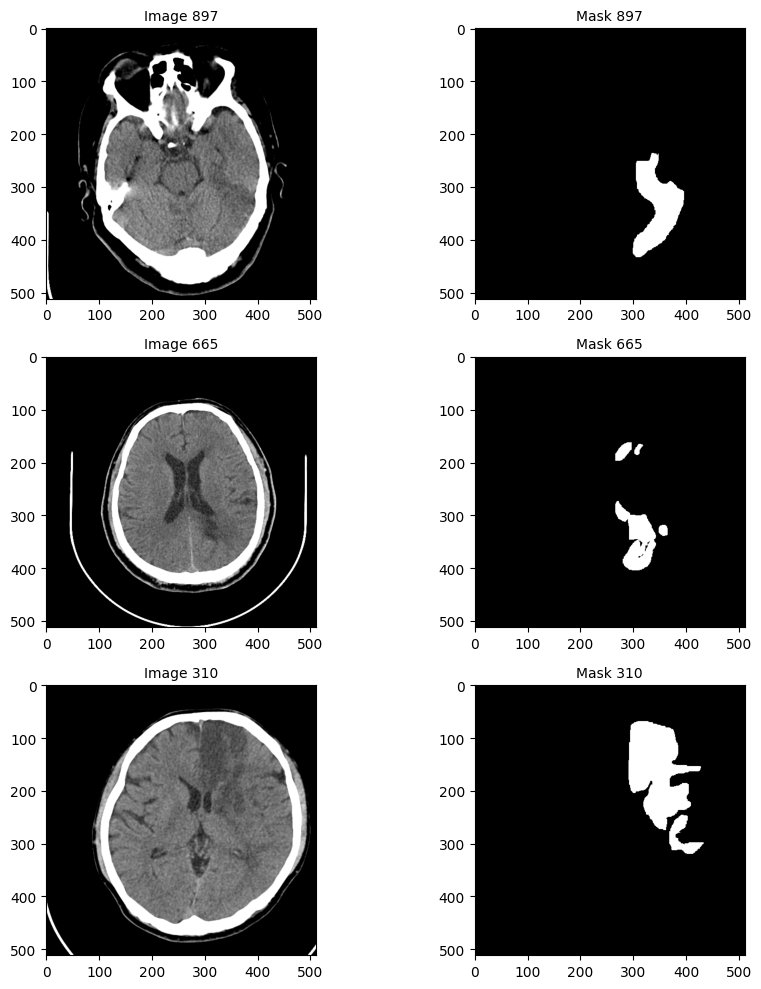

In [ ]:
num_samples = 3
random_indices = np.random.choice(len(images), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.05, hspace=0.3)

for i, idx in enumerate(random_indices):
    # Tampilkan image
    axes[i, 0].imshow(images[idx], cmap='gray')
    axes[i, 0].set_title(f"Image {idx}", fontsize=10)
    axes[i, 0].axis('on')

    # Tampilkan mask
    axes[i, 1].imshow(masks[idx], cmap='gray')
    axes[i, 1].set_title(f"Mask {idx}", fontsize=10)
    axes[i, 1].axis('on')

plt.tight_layout()
plt.show()

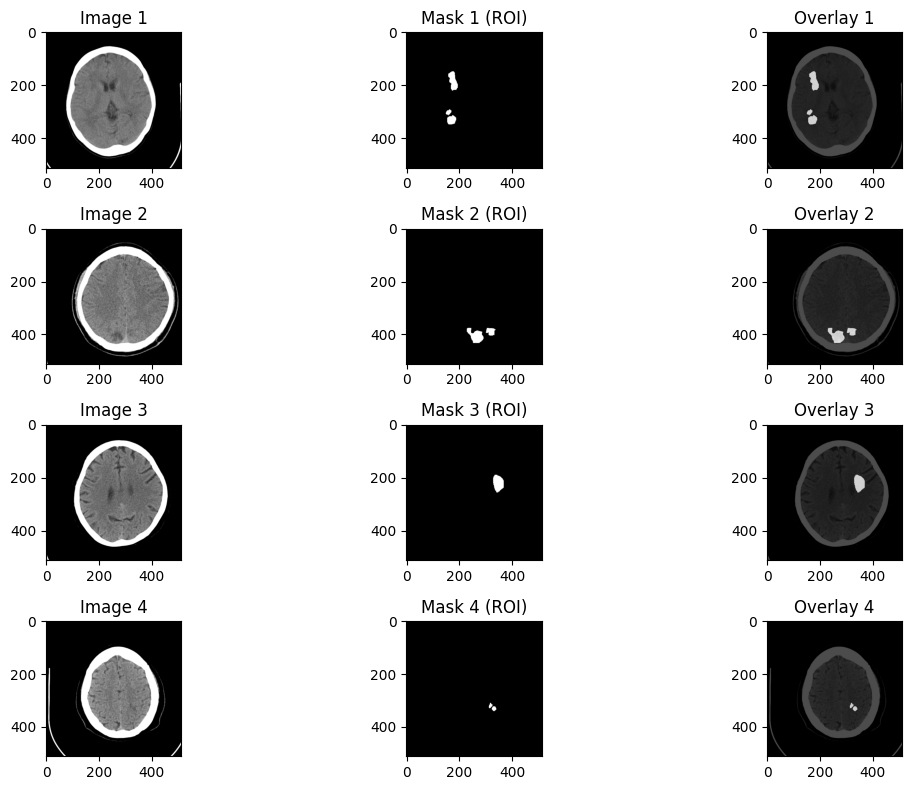

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

n_samples = 4  # jumlah contoh citra
plt.figure(figsize=(12, 8))

for row in range(n_samples):
    idx = random.randint(0, len(images)-1)

    img = images[idx]
    mask = masks[idx]

    # pastikan citra grayscale → convert ke 3 channel
    if len(img.shape) == 2:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img.copy()

    # normalisasi mask ke 0–255
    if mask.max() > 0:
        mask_norm = (mask.astype(np.float32) / mask.max() * 255).astype(np.uint8)
    else:
        mask_norm = mask.astype(np.uint8)

    # bikin mask putih (RGB)
    mask_color = np.zeros_like(img_rgb)
    mask_color[mask_norm > 0] = [255, 255, 255]   # putih

    # overlay (otak samar, lesi putih)
    overlay = cv2.addWeighted(img_rgb, 0.3, mask_color, 0.7, 0)

    # plotting: tiap row ada 3 panel
    plt.subplot(n_samples, 3, row*3 + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Image {row+1}")
    plt.axis("on")

    plt.subplot(n_samples, 3, row*3 + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {row+1} (ROI)")
    plt.axis("on")

    plt.subplot(n_samples, 3, row*3 + 3)
    plt.imshow(overlay)
    plt.title(f"Overlay {row+1}")
    plt.axis("on")

plt.tight_layout()
plt.show()


# Data Splitting
The data is divided into three parts: training data (**60%**), validation data (**15%**), and testing data (**25%**).

In [ ]:
# Split Data
from sklearn.model_selection import train_test_split

train_img, temp_img, train_msk, temp_mask, train_path, temp_path = train_test_split(
    images, masks, paths, test_size=0.4, random_state=42
)
val_img, test_img, val_msk, test_msk, val_path, test_path = train_test_split(
    temp_img, temp_mask, temp_path, test_size=0.75, random_state=42
)

print(f"Train size: {len(train_img)}")
print(f"Valid size: {len(val_img)}")
print(f"Test size: {len(test_img)}")


Train size: 633
Valid size: 105
Test size: 318


# Data Preprocessing
* **Image Resize** (512x512 -> 256x256)
* **Augmentation**
* **CLAHE** (Contrast Limited Adaptive Histogram Equalization)

In [ ]:
# Transformation for training
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.05, 0.05), rotate=(-10, 10), p=0.5),
    ToTensorV2()
])

# Transformation for validation (without augmentation)
val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

## `AISDStrokeDataset`
Custom PyTorch `Dataset` for loading CT images and stroke lesion masks. Handles optional preprocessing (HU clipping, CLAHE, log transform), augmentation, and outputs tensors in `(C, H, W)` format ready for training.

In [ ]:
# Class Dataset
class AISDStrokeDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, paths=None, transform=None,
                 use_clipping=False, hu_min=-100, hu_max=200,
                 use_clahe=False, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8),
                 use_log_transform=False, log_constant=None):

        self.images = images
        self.masks = masks
        self.paths = paths
        self.transform = transform

        self.use_clipping = use_clipping
        self.hu_min = hu_min
        self.hu_max = hu_max

        self.use_clahe = use_clahe
        self.clahe_clip_limit = clahe_clip_limit
        self.clahe_tile_grid_size = clahe_tile_grid_size

        self.use_log_transform = use_log_transform
        self.log_constant = log_constant

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        msk = self.masks[idx]

        # Ensuring grayscale
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        msk = np.squeeze(msk)                  # from (256, 256, 1) → (256, 256)


        # 1. Ensure that img & msk are 2D (H, W)
        if img.ndim != 2 or msk.ndim != 2:
            raise ValueError(f"Expected 2D input, got shape {img.shape} for image and {msk.shape} for mask")

        # 2. HU clipping (when enabled)
        if self.use_clipping:
            img = np.clip(img, self.hu_min, self.hu_max)
            img = (img - self.hu_min) / (self.hu_max - self.hu_min)
            img = (img * 255).astype(np.uint8)

        # 3. CLAHE (when enabled)
        if self.use_clahe:
            clahe = cv2.createCLAHE(clipLimit=self.clahe_clip_limit, tileGridSize=self.clahe_tile_grid_size)
            img = clahe.apply(img)

        # 4. Log Transform (when enabled)
        if self.use_log_transform:
            img = img.astype(np.float32) + 1.0  # biar gak log(0)
            if self.log_constant is None:
                c = np.max(img) / np.log(1.0 + np.max(img))
            else:
                c = self.log_constant
            img = c * np.log(img)

        # 4. Ensuring image = (H, W, 1)
        img = img[..., np.newaxis]
        msk = msk[..., np.newaxis]

        if self.transform:
            augmented = self.transform(image=img, mask=msk)
            img = augmented["image"]
            msk = augmented["mask"]

        msk = (msk > 0).float()

        msk = msk.permute(2, 0, 1)

        # 8. Return
        if self.paths is not None:
            return {"image": img, "mask": msk, "path": self.paths[idx]}
        else:
            return {"image": img, "mask": msk}


### Load the original dataset (without CLAHE)

In [ ]:
# Dataset Loader
train_Ori = AISDStrokeDataset(train_img, train_msk, paths=train_path, transform=train_transform, use_clipping=False, use_clahe=False, use_log_transform=False)
val_Ori   = AISDStrokeDataset(val_img, val_msk, paths=val_path, transform=val_transform, use_clipping=False, use_clahe=False, use_log_transform=False)
test_Ori  = AISDStrokeDataset(test_img, test_msk, paths=test_path, transform=val_transform, use_clipping=False, use_clahe=False, use_log_transform=False)

n_cpu = os.cpu_count()
train_loader_Ori = torch.utils.data.DataLoader(train_Ori, batch_size=4, shuffle=True, num_workers=0)
val_loader_Ori   = torch.utils.data.DataLoader(val_Ori, batch_size=4, shuffle=False, num_workers=0)
test_loader_Ori  = torch.utils.data.DataLoader(test_Ori, batch_size=4, shuffle=False, num_workers=0)

### Load the Transformed Dataset (CLAHE and Augmentation)

In [ ]:
# Dataset Loader
train_CLAHE = AISDStrokeDataset(train_img, train_msk, paths=train_path, transform=train_transform, use_clipping=False, use_clahe=True, clahe_clip_limit=5, clahe_tile_grid_size=(8, 8))
val_CLAHE   = AISDStrokeDataset(val_img, val_msk, paths=val_path, transform=val_transform, use_clipping=False, use_clahe=True, clahe_clip_limit=5, clahe_tile_grid_size=(8, 8))
test_CLAHE  = AISDStrokeDataset(test_img, test_msk, paths=test_path, transform=val_transform, use_clipping=False, use_clahe=True, clahe_clip_limit=5, clahe_tile_grid_size=(8, 8))

n_cpu = os.cpu_count()
train_loader_CLAHE = torch.utils.data.DataLoader(train_CLAHE, batch_size=4, shuffle=True, num_workers=0)
val_loader_CLAHE   = torch.utils.data.DataLoader(val_CLAHE, batch_size=4, shuffle=False, num_workers=0)
test_loader_CLAHE  = torch.utils.data.DataLoader(test_CLAHE, batch_size=4, shuffle=False, num_workers=0)

## Visualized Transformed Data

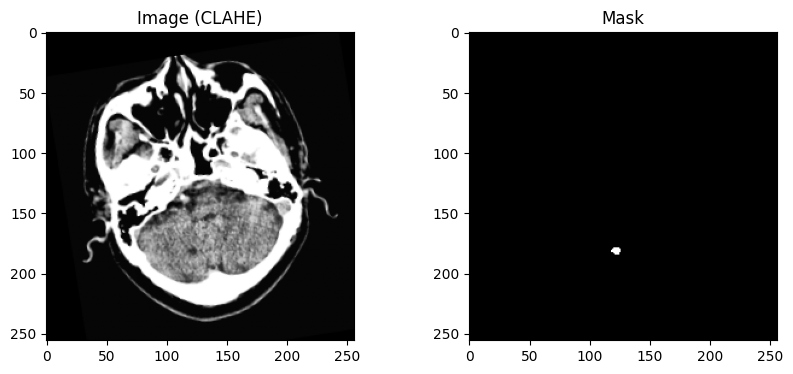

In [ ]:
# take 1 sample from the dataset
sample = train_CLAHE[25]

if isinstance(sample, dict):
    image = sample['image']
    mask = sample['mask']
else:
    image, mask, *_ = sample

# if the image/mask is still in tensor form
if isinstance(image, torch.Tensor):
    image = image.numpy()
if isinstance(mask, torch.Tensor):
    mask = mask.numpy()

# squeeze the channel if necessary
if image.ndim == 3:
    image = np.squeeze(image)
if mask.ndim == 3:
    mask = np.squeeze(mask)

# plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Image (CLAHE)')
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('on')

plt.show()


# Build the Model (UNet++ + CNN)
Hyperparameters:
* **Epoch:** 100
* **Optimizer:** Adam
* **Loss function:** Dice + BCE Loss
* **Learning rate:** 2e-4


In [ ]:
# Some training hyperparameters
EPOCHS = 100
T_MAX = EPOCHS * len(train_loader_CLAHE)
OUT_CLASSES = 1

## Build model using custom Pytorch Lightning Module
`StrokeModel` is a PyTorch Lightning module for binary stroke lesion segmentation using models from `segmentation_models_pytorch`.

In [ ]:
# Model
class StrokeModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, irfn_channels, out_classes,
                 optimizer_name="Adam", learning_rate=2e-4,
                 scheduler_name="CosineAnnealingLR", **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        self.optimizer_name = optimizer_name
        self.learning_rate = learning_rate
        self.scheduler_name = scheduler_name

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss()

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        dice = self.dice_loss(logits_mask, mask)
        bce = self.bce_loss(logits_mask, mask)
        loss = dice + bce

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        loss = torch.stack([x["loss"] for x in outputs]).mean()

        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        dice = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")  # Dice == F1

        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_precision", precision, prog_bar=True)
        self.log(f"{stage}_recall", recall, prog_bar=True)
        self.log(f"{stage}_f1", f1, prog_bar=True)
        self.log(f"{stage}_iou", iou, prog_bar=True)
        self.log(f"{stage}_dice", dice, prog_bar=True)

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")

        tp = torch.cat([x["tp"] for x in self.test_step_outputs])
        fp = torch.cat([x["fp"] for x in self.test_step_outputs])
        fn = torch.cat([x["fn"] for x in self.test_step_outputs])
        tn = torch.cat([x["tn"] for x in self.test_step_outputs])

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        self.test_step_outputs.clear()

        return {
            "test_per_image_iou": per_image_iou,
            "test_dataset_iou": dataset_iou,
        }


    def configure_optimizers(self):
      if self.optimizer_name == "Adam":
          optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      elif self.optimizer_name == "SGD":
          optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
      elif self.optimizer_name == "AdamW":
          optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
      else:
          raise ValueError(f"Unknown optimizer: {self.optimizer_name}")

      if self.scheduler_name == "CosineAnnealingLR":
          scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
      elif self.scheduler_name == "ReduceLROnPlateau":
          scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
      else:
          scheduler = None  # atau raise error juga boleh

      if scheduler:
          return {
              "optimizer": optimizer,
              "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # atau "epoch" sesuai scheduler-nya
                "frequency": 1,
              },
          }
      else:
         return optimizer


# MODEL 1 TRAINING (UNet++ + MobileNetV3)

In [ ]:
model1 = StrokeModel("UnetPlusPlus", encoder_name="tu-mobilenetv3_large_100", in_channels=3, out_classes=1, optimizer_name="Adam", learning_rate=2e-4, scheduler_name="CosineAnnealingLR")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

In [ ]:
print(model)

StrokeModel(
  (model): UnetPlusPlus(
    (encoder): TimmUniversalEncoder(
      (model): MobileNetV3Features(
        (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Hardswish()
        (blocks): Sequential(
          (0): Sequential(
            (0): DepthwiseSeparableConv(
              (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (bn1): BatchNormAct2d(
                16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (aa): Identity()
              (se): Identity()
              (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn2): BatchNormAct2d(
                16, eps=1e-05, momentum=0.1, affine=True,

Enabled `Early stopping` (patience 20) and `Checkpoint`

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping
early_stop_callback = EarlyStopping(
    monitor='valid_loss',           # metrik yang dipantau
    patience=20,                   # kalau ga membaik selama 5 epoch, stop
    mode='min',                   # 'min' karena val_loss makin kecil makin bagus
    verbose=True
)

# Model Checkpoint (buat nyimpen model terbaik)
checkpoint_callback = ModelCheckpoint(
    monitor='valid_dice',
    dirpath='checkpoints/',       # folder tempat nyimpen model
    filename='best-checkpoint',   # nama file model
    save_top_k=1,                 # cuma simpen model terbaik
    mode='max'
)

In [ ]:
# Training
logger = TensorBoardLogger("lightning_logs", name="stroke")

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)

trainer.fit(
    model1,
    train_dataloaders=train_loader_CLAHE,
    val_dataloaders=val_loader_CLAHE,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | model     | UnetPlusPlus          | 6.9 M  | train
1 | dice_loss | DiceLoss              | 0      | train
2 | bce_loss  | SoftBCEWithLogitsLoss | 0      | train
------------------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.669    Total estimated model params size (MB)
442       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved. New best score: 0.891


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.238 >= min_delta = 0.0. New best score: 0.652


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.603


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.106 >= min_delta = 0.0. New best score: 0.497


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.496


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.489


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.468


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.417


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.416


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.409


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.389


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric valid_loss did not improve in the last 20 records. Best score: 0.389. Signaling Trainer to stop.


In [ ]:
print(model1.trainer.callback_metrics)

{'valid_loss': tensor(0.5403), 'valid_precision': tensor(0.8872), 'valid_recall': tensor(0.5161), 'valid_f1': tensor(0.6526), 'valid_iou': tensor(0.4843), 'valid_dice': tensor(0.6526), 'valid_per_image_iou': tensor(0.2829), 'valid_dataset_iou': tensor(0.4843), 'train_loss': tensor(0.3699), 'train_precision': tensor(0.7943), 'train_recall': tensor(0.7396), 'train_f1': tensor(0.7659), 'train_iou': tensor(0.6207), 'train_dice': tensor(0.7659), 'train_per_image_iou': tensor(0.3845), 'train_dataset_iou': tensor(0.6207)}


## Model 1 Testing using best model
The evaluation metrics used are as follows:
* Intersection over Union (IoU)
* Dice
* Number of parameters
* Inference time

In [ ]:
# Load best checkpoint
best_model_path1 = "/content/checkpoints/best-checkpoint-v4.ckpt"
best_model1 = StrokeModel.load_from_checkpoint(
    best_model_path1,
    arch="UnetPlusPlus",
    encoder_name="tu-mobilenetv3_large_100",
    in_channels=3,
    out_classes=1,
)

# Testing
trainer = pl.Trainer(logger=False)
trainer.test(best_model1, dataloaders=test_loader_CLAHE)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_dataset_iou      │    0.5714952945709229     │
│         test_dice         │    0.7273267507553101     │
│          test_f1          │    0.7273267507553101     │
│         test_iou          │    0.5714952945709229     │
│         test_loss         │    0.43920212984085083    │
│    test_per_image_iou     │    0.3620258569717407     │
│      test_precision       │    0.7907611131668091     │
│        test_recall        │    0.6733139157295227     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.43920212984085083,
  'test_precision': 0.7907611131668091,
  'test_recall': 0.6733139157295227,
  'test_f1': 0.7273267507553101,
  'test_iou': 0.5714952945709229,
  'test_dice': 0.7273267507553101,
  'test_per_image_iou': 0.3620258569717407,
  'test_dataset_iou': 0.5714952945709229}]

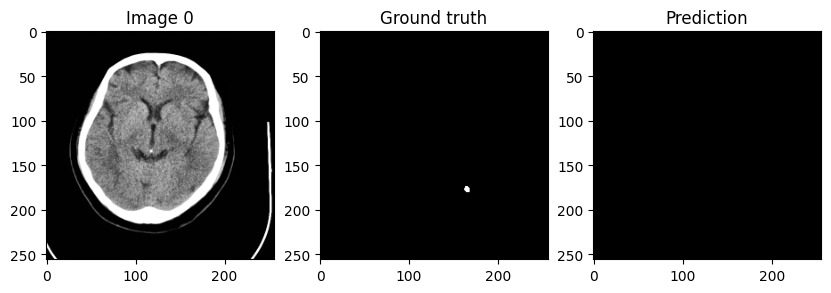

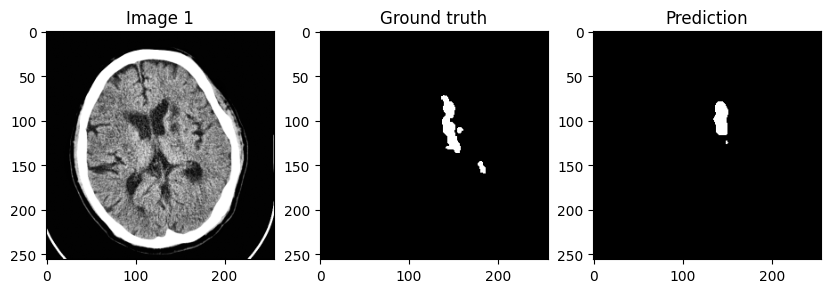

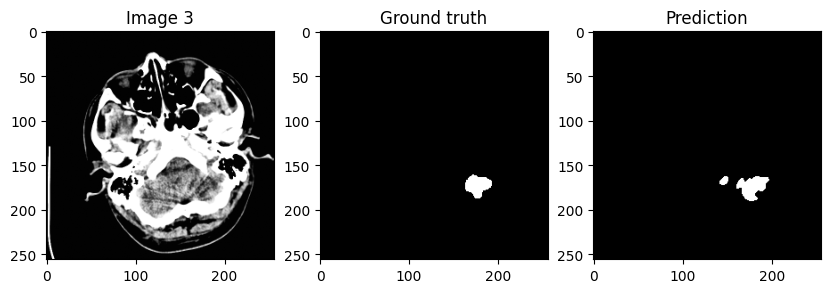

In [ ]:
batch = random.choice(list(test_loader_CLAHE))
with torch.inference_mode():
    best_model1.eval()
    logits1 = best_model1(batch["image"])
pr_masks1 = logits1.sigmoid()

pr_masks_bin1 = (pr_masks1 > 0.5).float()

# Ambil 3 indeks random dari batch
n_img = len(batch["image"])
idx_list = random.sample(range(n_img), min(3, n_img))

for idx in idx_list:
    images = batch["image"][idx]
    gt_mask = batch["mask"][idx]
    pr_mask1 = pr_masks_bin1[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title(f"Image {idx}")
    plt.axis("on")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
    plt.title("Ground truth")
    plt.axis("on")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask1.numpy().squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis("on")


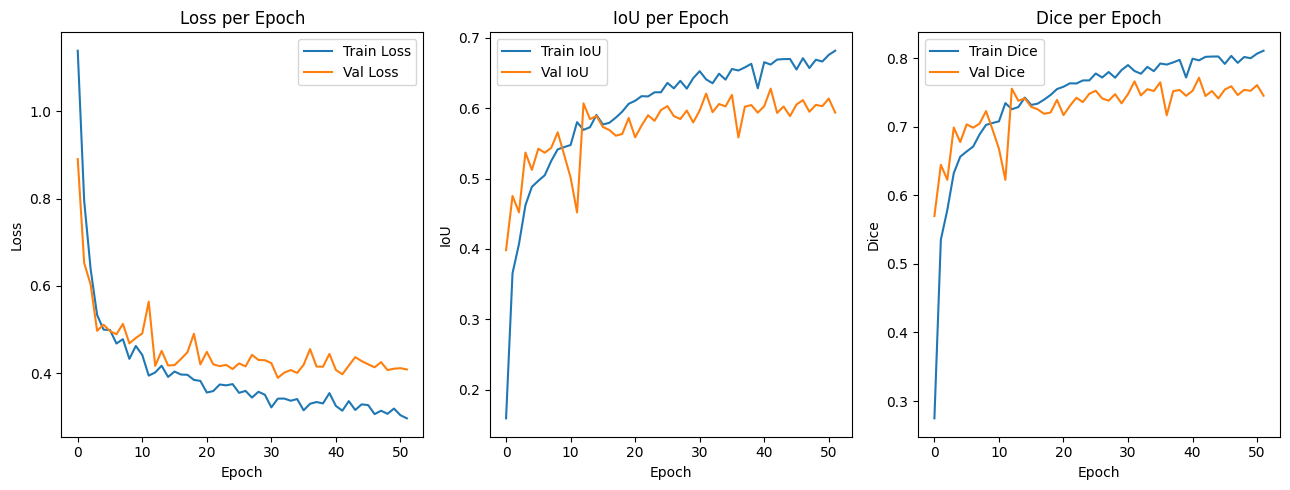

In [ ]:
ea = event_accumulator.EventAccumulator('/content/lightning_logs/stroke/version_4')
ea.Reload()

# ambil loss dan iou dari log
train_loss = ea.Scalars('train_loss')
val_loss = ea.Scalars('valid_loss')
train_iou = ea.Scalars('train_iou')
val_iou = ea.Scalars('valid_iou')
train_dice = ea.Scalars('train_dice')
val_dice = ea.Scalars('valid_dice')

# ekstrak value
steps_per_epoch = len(train_loader_CLAHE)  # atau sesuai train loader kamu
epochs = [step // steps_per_epoch for step in [x.step for x in train_loss]]
train_loss_vals = [x.value for x in train_loss]
val_loss_vals = [x.value for x in val_loss]
train_iou_vals = [x.value for x in train_iou]
val_iou_vals = [x.value for x in val_iou]
train_dice_vals = [x.value for x in train_dice]
val_dice_vals = [x.value for x in val_dice]

# plot
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_vals, label='Train Loss')
plt.plot(epochs, val_loss_vals, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_iou_vals, label='Train IoU')
plt.plot(epochs, val_iou_vals, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_dice_vals, label='Train Dice')
plt.plot(epochs, val_dice_vals, label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Model 2 Training (UNet++ + ResNet34)

In [ ]:
model2 = StrokeModel("UnetPlusPlus", encoder_name="resnet34", in_channels=3, out_classes=1, optimizer_name="Adam", learning_rate=2e-4, scheduler_name="CosineAnnealingLR")

In [ ]:
print(model)

StrokeModel(
  (model): UnetPlusPlus(
    (encoder): TimmUniversalEncoder(
      (model): MobileNetV3Features(
        (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Hardswish()
        (blocks): Sequential(
          (0): Sequential(
            (0): DepthwiseSeparableConv(
              (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (bn1): BatchNormAct2d(
                16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (aa): Identity()
              (se): Identity()
              (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn2): BatchNormAct2d(
                16, eps=1e-05, momentum=0.1, affine=True,

Enabled `Early stopping` (patience 20) and `Checkpoint`

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping
early_stop_callback = EarlyStopping(
    monitor='valid_loss',           # metrik yang dipantau
    patience=20,                   # kalau ga membaik selama 5 epoch, stop
    mode='min',                   # 'min' karena val_loss makin kecil makin bagus
    verbose=True
)

# Model Checkpoint (buat nyimpen model terbaik)
checkpoint_callback = ModelCheckpoint(
    monitor='valid_dice',
    dirpath='checkpoints/',       # folder tempat nyimpen model
    filename='best-checkpoint',   # nama file model
    save_top_k=1,                 # cuma simpen model terbaik
    mode='max'
)

In [ ]:
# Training
logger = TensorBoardLogger("lightning_logs", name="stroke")

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)

trainer.fit(
    model2,
    train_dataloaders=train_loader_CLAHE,
    val_dataloaders=val_loader_CLAHE ,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | model     | UnetPlusPlus          | 26.1 M | train
1 | dice_loss | DiceLoss              | 0      | train
2 | bce_loss  | SoftBCEWithLogitsLoss | 0      | train
------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.314   Total estimated model params size (MB)
268       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved. New best score: 1.048


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.434 >= min_delta = 0.0. New best score: 0.614


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.527


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.506


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.490


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.478


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.472


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.428


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.420


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.412


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.407


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.402


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric valid_loss did not improve in the last 20 records. Best score: 0.402. Signaling Trainer to stop.


## Model 2 Testing using best model
The evaluation metrics used are as follows:
* Intersection over Union (IoU)
* Dice
* Number of parameters
* Inference time

In [ ]:
# Load best checkpoint
best_model_path2 = "/content/checkpoints/best-checkpoint-v5.ckpt"
best_model2 = StrokeModel.load_from_checkpoint(
    best_model_path2,
    arch="UnetPlusPlus",
    encoder_name="resnet34",
    in_channels=3,
    out_classes=1,
)

# Testing
trainer = pl.Trainer(logger=False)
trainer.test(best_model2, dataloaders=test_loader_CLAHE)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_dataset_iou      │    0.5214565992355347     │
│         test_dice         │    0.6854702234268188     │
│          test_f1          │    0.6854702234268188     │
│         test_iou          │    0.5214565992355347     │
│         test_loss         │    0.5015174746513367     │
│    test_per_image_iou     │    0.31870946288108826    │
│      test_precision       │    0.7660238146781921     │
│        test_recall        │    0.6202462911605835     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5015174746513367,
  'test_precision': 0.7660238146781921,
  'test_recall': 0.6202462911605835,
  'test_f1': 0.6854702234268188,
  'test_iou': 0.5214565992355347,
  'test_dice': 0.6854702234268188,
  'test_per_image_iou': 0.31870946288108826,
  'test_dataset_iou': 0.5214565992355347}]

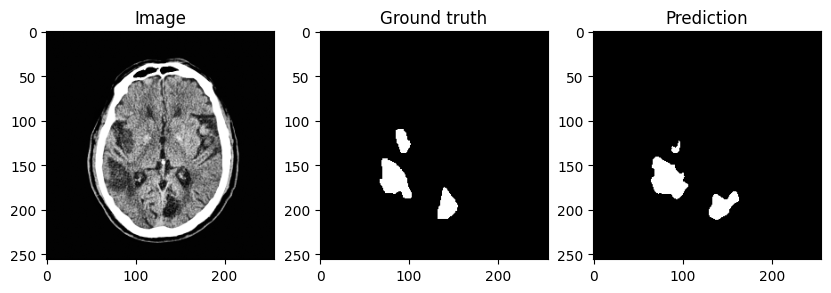

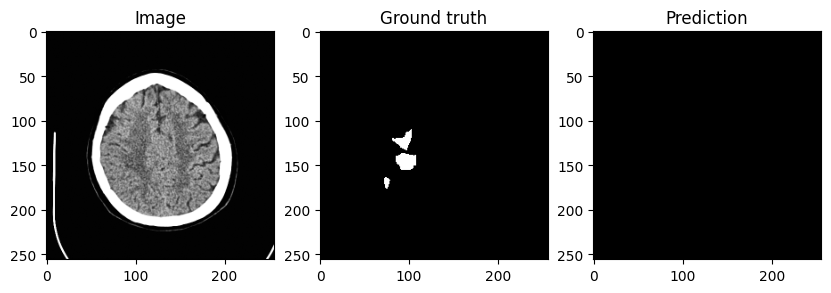

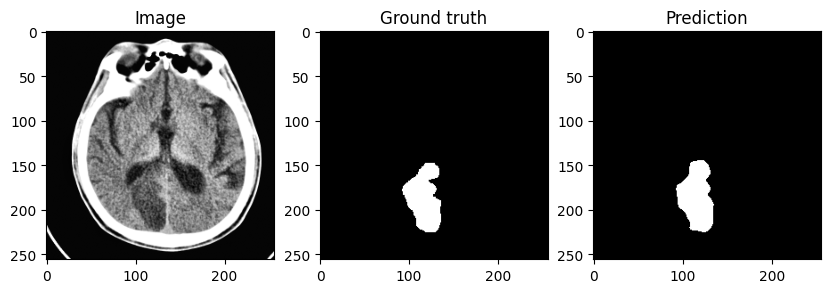

In [ ]:
batch = random.choice(list(test_loader_CLAHE))
with torch.inference_mode():
    best_model2.eval()
    logits2 = best_model2(batch["image"])
pr_masks2 = logits2.sigmoid()

pr_masks_bin2 = (pr_masks2 > 0.5).float()

# Ambil 3 indeks random dari batch
n_img = len(batch["image"])
idx_list = random.sample(range(n_img), min(3, n_img))

for idx in idx_list:
    images = batch["image"][idx]
    gt_mask = batch["mask"][idx]
    pr_mask2 = pr_masks_bin2[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Image")
    plt.axis("on")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
    plt.title("Ground truth")
    plt.axis("on")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask2.numpy().squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis("on")


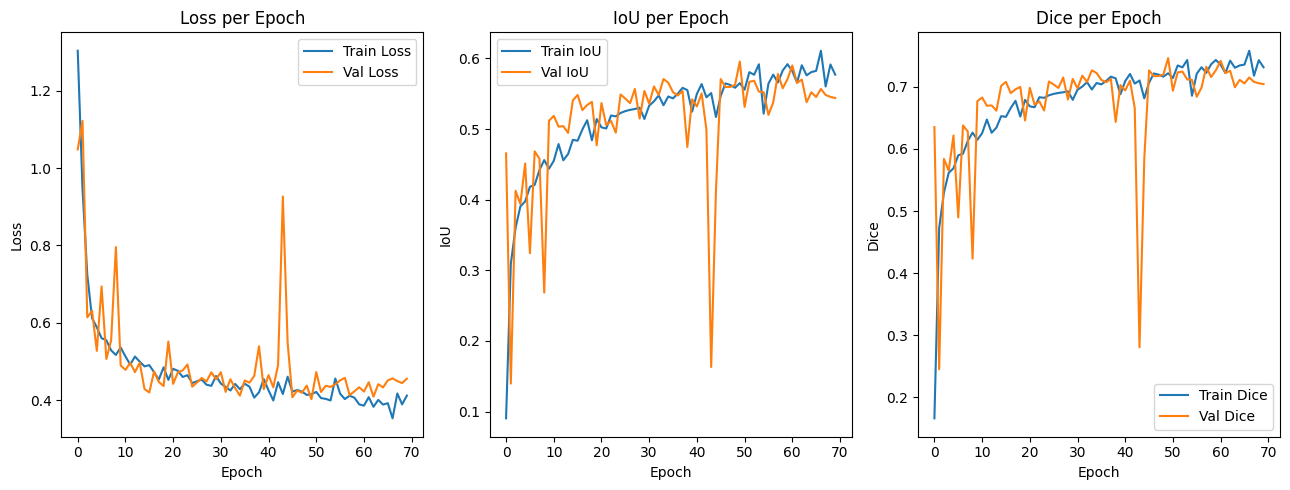

In [ ]:
ea = event_accumulator.EventAccumulator('/content/lightning_logs/stroke/version_5')
ea.Reload()

# ambil loss dan iou dari log
train_loss = ea.Scalars('train_loss')
val_loss = ea.Scalars('valid_loss')
train_iou = ea.Scalars('train_iou')
val_iou = ea.Scalars('valid_iou')
train_dice = ea.Scalars('train_dice')
val_dice = ea.Scalars('valid_dice')

# ekstrak value
steps_per_epoch = len(train_loader_CLAHE)  # atau sesuai train loader kamu
epochs = [step // steps_per_epoch for step in [x.step for x in train_loss]]
train_loss_vals = [x.value for x in train_loss]
val_loss_vals = [x.value for x in val_loss]
train_iou_vals = [x.value for x in train_iou]
val_iou_vals = [x.value for x in val_iou]
train_dice_vals = [x.value for x in train_dice]
val_dice_vals = [x.value for x in val_dice]

# plot
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_vals, label='Train Loss')
plt.plot(epochs, val_loss_vals, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_iou_vals, label='Train IoU')
plt.plot(epochs, val_iou_vals, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_dice_vals, label='Train Dice')
plt.plot(epochs, val_dice_vals, label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Model 3 Training (UNet++ + EfficientNetB1)

In [ ]:
 model3 = StrokeModel("UnetPlusPlus", encoder_name="efficientnet-b1", in_channels=3, out_classes=1, optimizer_name="Adam", learning_rate=2e-4, scheduler_name="CosineAnnealingLR")

In [ ]:
print(model)

StrokeModel(
  (model): UnetPlusPlus(
    (encoder): TimmUniversalEncoder(
      (model): MobileNetV3Features(
        (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Hardswish()
        (blocks): Sequential(
          (0): Sequential(
            (0): DepthwiseSeparableConv(
              (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (bn1): BatchNormAct2d(
                16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (aa): Identity()
              (se): Identity()
              (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn2): BatchNormAct2d(
                16, eps=1e-05, momentum=0.1, affine=True,

Enabled `Early stopping` (patience 20) and `Checkpoint`

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping
early_stop_callback = EarlyStopping(
    monitor='valid_loss',           # metrik yang dipantau
    patience=20,                   # kalau ga membaik selama 5 epoch, stop
    mode='min',                   # 'min' karena val_loss makin kecil makin bagus
    verbose=True
)

# Model Checkpoint (buat nyimpen model terbaik)
checkpoint_callback = ModelCheckpoint(
    monitor='valid_dice',
    dirpath='checkpoints/',       # folder tempat nyimpen model
    filename='best-checkpoint',   # nama file model
    save_top_k=1,                 # cuma simpen model terbaik
    mode='max'
)

In [ ]:
# Training
logger = TensorBoardLogger("lightning_logs", name="stroke")

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)

trainer.fit(
    model3,
    train_dataloaders=train_loader_CLAHE,
    val_dataloaders=val_loader_CLAHE ,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | model     | UnetPlusPlus          | 9.1 M  | train
1 | dice_loss | DiceLoss              | 0      | train
2 | bce_loss  | SoftBCEWithLogitsLoss | 0      | train
------------------------------------------------------------
9.1 M     Trainable params
0         Non-trainable params
9.1 M     Total params
36.301    Total estimated model params size (MB)
508       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved. New best score: 1.063


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.282 >= min_delta = 0.0. New best score: 0.781


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.198 >= min_delta = 0.0. New best score: 0.583


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.573


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.524


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.498


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.455


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.437


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.423


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.397


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.393


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.379


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.377


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.364


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric valid_loss did not improve in the last 20 records. Best score: 0.364. Signaling Trainer to stop.


## Model 3 Testing using best model
The evaluation metrics used are as follows:
* Intersection over Union (IoU)
* Dice
* Number of parameters
* Inference time

In [ ]:
# Load best checkpoint
best_model_path3 = "/content/checkpoints/best-checkpoint-v8.ckpt"
best_model3 = StrokeModel.load_from_checkpoint(
    best_model_path3,
    arch="UnetPlusPlus",
    encoder_name="efficientnet-b1",
    in_channels=3,
    out_classes=1,
)

# Testing
trainer = pl.Trainer(logger=False)
trainer.test(best_model3, dataloaders=test_loader_CLAHE)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_dataset_iou      │    0.5886421799659729     │
│         test_dice         │    0.7410632371902466     │
│          test_f1          │    0.7410632371902466     │
│         test_iou          │    0.5886421799659729     │
│         test_loss         │    0.43119239807128906    │
│    test_per_image_iou     │    0.36966079473495483    │
│      test_precision       │    0.8348215818405151     │
│        test_recall        │    0.6662384271621704     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.43119239807128906,
  'test_precision': 0.8348215818405151,
  'test_recall': 0.6662384271621704,
  'test_f1': 0.7410632371902466,
  'test_iou': 0.5886421799659729,
  'test_dice': 0.7410632371902466,
  'test_per_image_iou': 0.36966079473495483,
  'test_dataset_iou': 0.5886421799659729}]

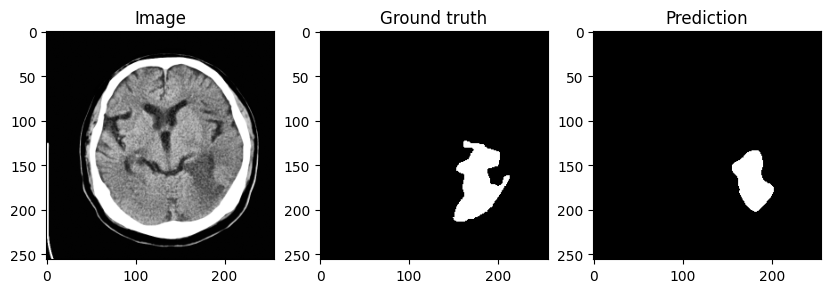

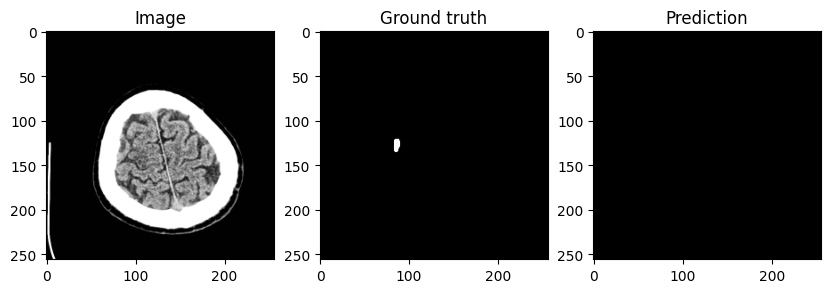

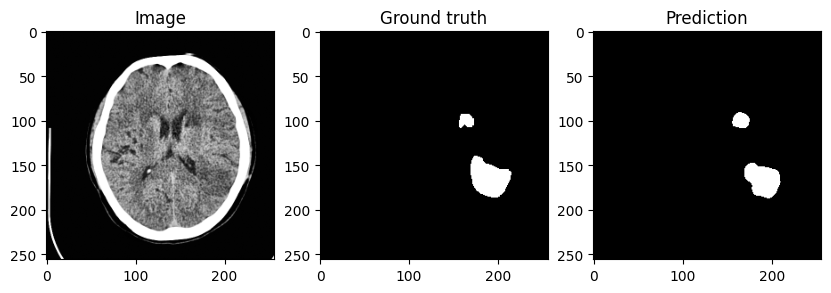

In [ ]:
batch = random.choice(list(test_loader_CLAHE))
with torch.inference_mode():
    best_model3.eval()
    logits3 = best_model3(batch["image"])
pr_masks3 = logits3.sigmoid()

pr_masks_bin3 = (pr_masks3 > 0.5).float()

# Ambil 3 indeks random dari batch
n_img = len(batch["image"])
idx_list = random.sample(range(n_img), min(3, n_img))

for idx in idx_list:
    images = batch["image"][idx]
    gt_mask = batch["mask"][idx]
    pr_mask3 = pr_masks_bin3[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Image")
    plt.axis("on")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
    plt.title("Ground truth")
    plt.axis("on")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask3.numpy().squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis("on")


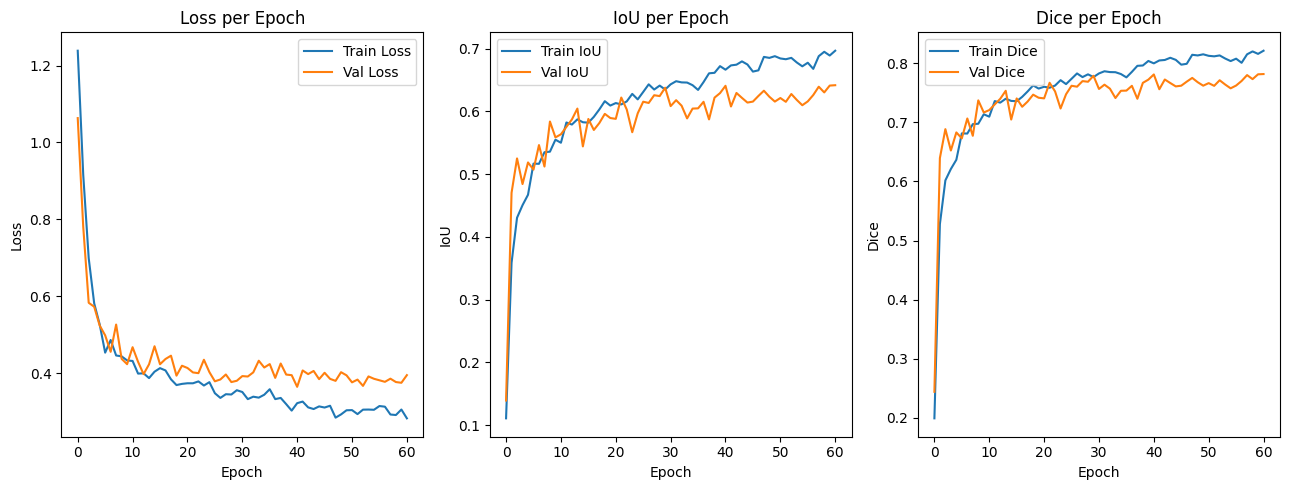

In [ ]:
ea = event_accumulator.EventAccumulator('/content/lightning_logs/stroke/version_9')
ea.Reload()

# ambil loss dan iou dari log
train_loss = ea.Scalars('train_loss')
val_loss = ea.Scalars('valid_loss')
train_iou = ea.Scalars('train_iou')
val_iou = ea.Scalars('valid_iou')
train_dice = ea.Scalars('train_dice')
val_dice = ea.Scalars('valid_dice')

# ekstrak value
steps_per_epoch = len(train_loader_CLAHE)  # atau sesuai train loader kamu
epochs = [step // steps_per_epoch for step in [x.step for x in train_loss]]
train_loss_vals = [x.value for x in train_loss]
val_loss_vals = [x.value for x in val_loss]
train_iou_vals = [x.value for x in train_iou]
val_iou_vals = [x.value for x in val_iou]
train_dice_vals = [x.value for x in train_dice]
val_dice_vals = [x.value for x in val_dice]

# plot
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_vals, label='Train Loss')
plt.plot(epochs, val_loss_vals, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_iou_vals, label='Train IoU')
plt.plot(epochs, val_iou_vals, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_dice_vals, label='Train Dice')
plt.plot(epochs, val_dice_vals, label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Model 4 Training (UNet++ + VGG16)

In [ ]:
model4 = StrokeModel("UnetPlusPlus", encoder_name="vgg16", in_channels=3, out_classes=1, optimizer_name="Adam", learning_rate=2e-4, scheduler_name="CosineAnnealingLR")

In [ ]:
print(model)

StrokeModel(
  (model): UnetPlusPlus(
    (encoder): TimmUniversalEncoder(
      (model): MobileNetV3Features(
        (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Hardswish()
        (blocks): Sequential(
          (0): Sequential(
            (0): DepthwiseSeparableConv(
              (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (bn1): BatchNormAct2d(
                16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (aa): Identity()
              (se): Identity()
              (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn2): BatchNormAct2d(
                16, eps=1e-05, momentum=0.1, affine=True,

Enabled `Early stopping` (patience 20) and `Checkpoint`

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping
early_stop_callback = EarlyStopping(
    monitor='valid_loss',           # metrik yang dipantau
    patience=20,                   # kalau ga membaik selama 5 epoch, stop
    mode='min',                   # 'min' karena val_loss makin kecil makin bagus
    verbose=True
)

# Model Checkpoint (buat nyimpen model terbaik)
checkpoint_callback = ModelCheckpoint(
    monitor='valid_dice',
    dirpath='checkpoints/',       # folder tempat nyimpen model
    filename='best-checkpoint',   # nama file model
    save_top_k=1,                 # cuma simpen model terbaik
    mode='max'
)

In [ ]:
# Training
logger = TensorBoardLogger("lightning_logs", name="stroke")

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)

trainer.fit(
    model4,
    train_dataloaders=train_loader_CLAHE,
    val_dataloaders=val_loader_CLAHE ,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | model     | UnetPlusPlus          | 39.3 M | train
1 | dice_loss | DiceLoss              | 0      | train
2 | bce_loss  | SoftBCEWithLogitsLoss | 0      | train
------------------------------------------------------------
39.3 M    Trainable params
0         Non-trainable params
39.3 M    Total params
157.389   Total estimated model params size (MB)
196       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric valid_loss did not improve in the last 21 records. Best score: 0.406. Signaling Trainer to stop.


## Model 4 Testing using best model
The evaluation metrics used are as follows:
* Intersection over Union (IoU)
* Dice
* Number of parameters
* Inference time

In [ ]:
# Load best checkpoint
best_model_path4 = "/content/checkpoints/best-checkpoint-v6.ckpt"
best_model4 = StrokeModel.load_from_checkpoint(
    best_model_path4,
    arch="UnetPlusPlus",
    encoder_name="vgg16",
    in_channels=3,
    out_classes=1,
)

# Testing
trainer = pl.Trainer(logger=False)
trainer.test(best_model4, dataloaders=test_loader_CLAHE)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_dataset_iou      │    0.5157201886177063     │
│         test_dice         │    0.6804952621459961     │
│          test_f1          │    0.6804952621459961     │
│         test_iou          │    0.5157201886177063     │
│         test_loss         │    0.4999399185180664     │
│    test_per_image_iou     │    0.30404072999954224    │
│      test_precision       │    0.7582017183303833     │
│        test_recall        │    0.6172360181808472     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4999399185180664,
  'test_precision': 0.7582017183303833,
  'test_recall': 0.6172360181808472,
  'test_f1': 0.6804952621459961,
  'test_iou': 0.5157201886177063,
  'test_dice': 0.6804952621459961,
  'test_per_image_iou': 0.30404072999954224,
  'test_dataset_iou': 0.5157201886177063}]

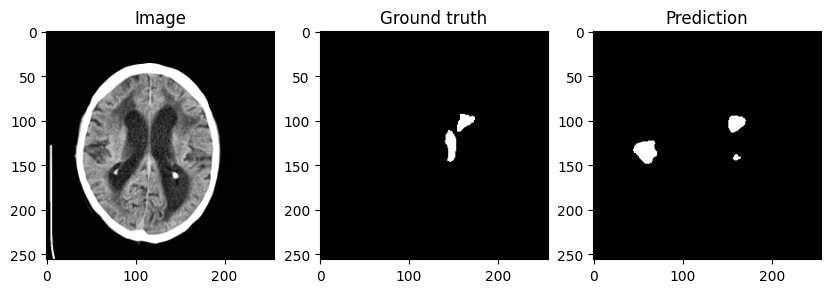

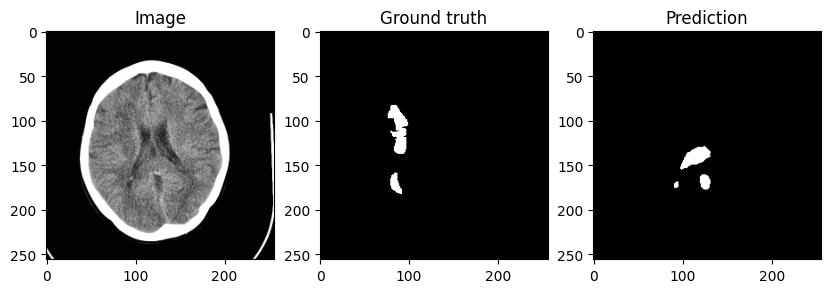

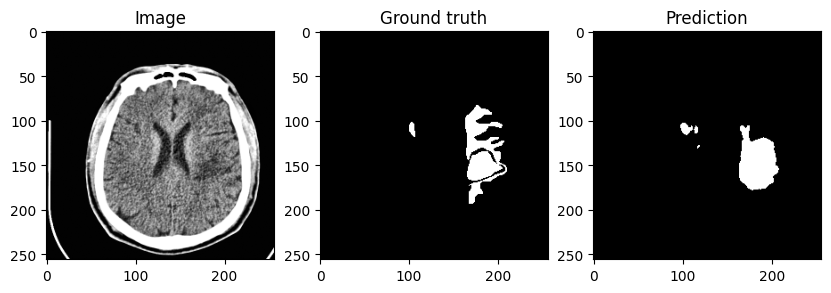

In [ ]:
batch = random.choice(list(test_loader_CLAHE))
with torch.inference_mode():
    best_model4.eval()
    logits4 = best_model4(batch["image"])
pr_masks4 = logits4.sigmoid()

pr_masks_bin4 = (pr_masks4 > 0.5).float()

# Ambil 3 indeks random dari batch
n_img = len(batch["image"])
idx_list = random.sample(range(n_img), min(3, n_img))

for idx in idx_list:
    images = batch["image"][idx]
    gt_mask = batch["mask"][idx]
    pr_mask4 = pr_masks_bin4[idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Image")
    plt.axis("on")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
    plt.title("Ground truth")
    plt.axis("on")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask4.numpy().squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis("on")


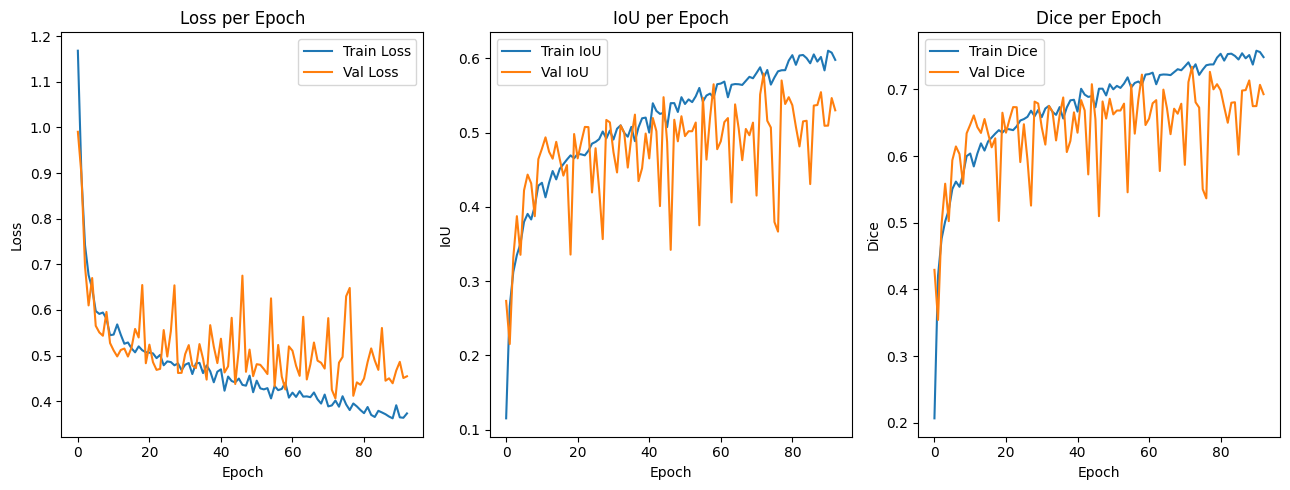

In [ ]:
ea = event_accumulator.EventAccumulator('/content/lightning_logs/stroke/version_6')
ea.Reload()

# ambil loss dan iou dari log
train_loss = ea.Scalars('train_loss')
val_loss = ea.Scalars('valid_loss')
train_iou = ea.Scalars('train_iou')
val_iou = ea.Scalars('valid_iou')
train_dice = ea.Scalars('train_dice')
val_dice = ea.Scalars('valid_dice')

# ekstrak value
steps_per_epoch = len(train_loader_CLAHE)  # atau sesuai train loader kamu
epochs = [step // steps_per_epoch for step in [x.step for x in train_loss]]
train_loss_vals = [x.value for x in train_loss]
val_loss_vals = [x.value for x in val_loss]
train_iou_vals = [x.value for x in train_iou]
val_iou_vals = [x.value for x in val_iou]
train_dice_vals = [x.value for x in train_dice]
val_dice_vals = [x.value for x in val_dice]

# plot
plt.figure(figsize=(13, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_vals, label='Train Loss')
plt.plot(epochs, val_loss_vals, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_iou_vals, label='Train IoU')
plt.plot(epochs, val_iou_vals, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_dice_vals, label='Train Dice')
plt.plot(epochs, val_dice_vals, label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Select One Random Image to be Segmented with Each Model

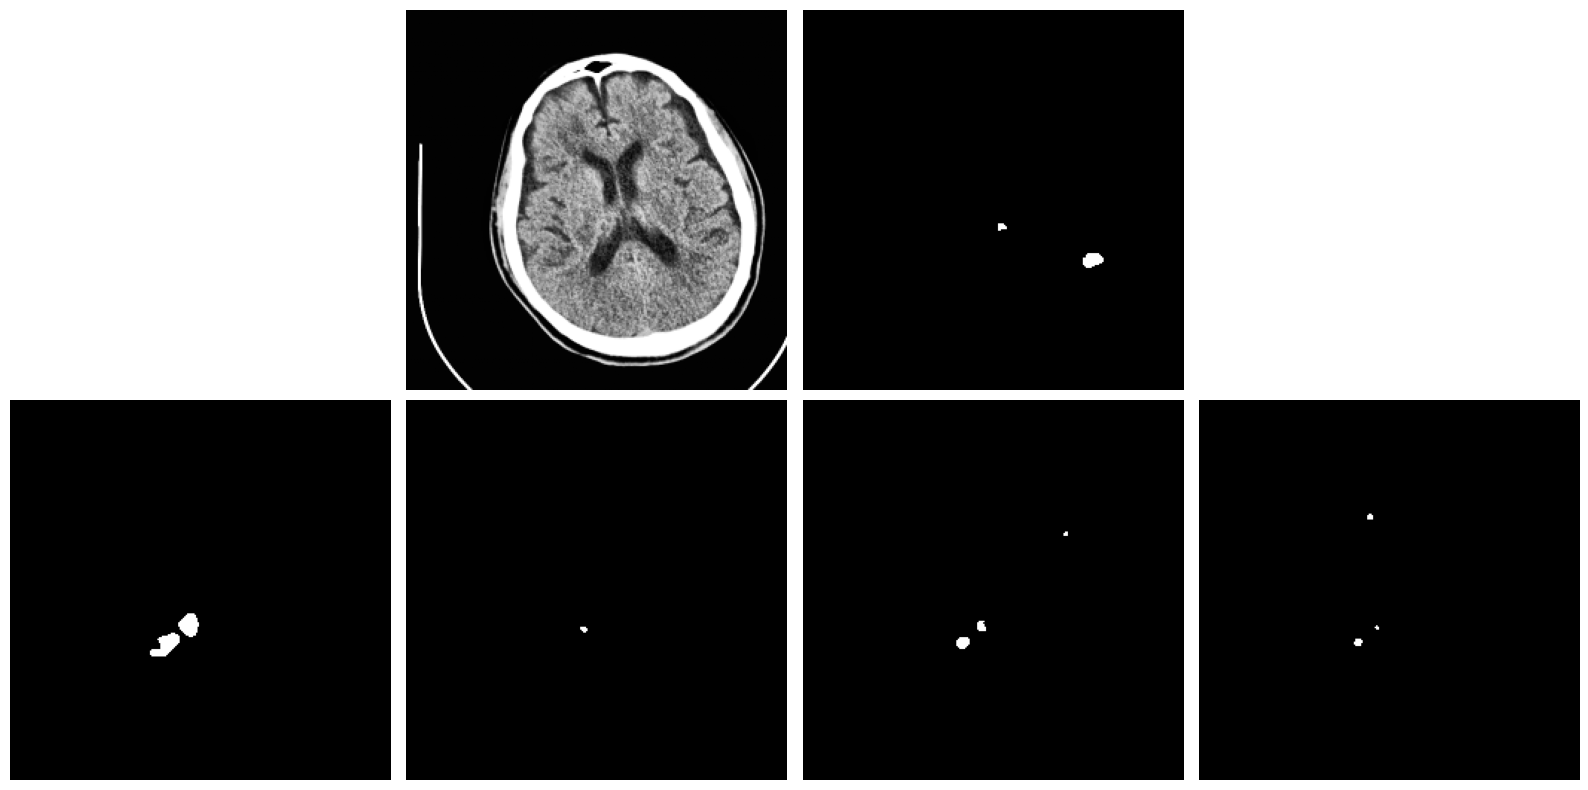

In [ ]:
# ----------------------------
# Pick 1 random batch
# ----------------------------
batch = random.choice(list(test_loader_CLAHE))
images = batch["image"]
gt_masks = batch["mask"]

# ----------------------------
# Pick 1 random index
# ----------------------------
n_img = len(images)
idx = random.choice(range(n_img))

# ----------------------------
# Inference of all models for sample idx
# ----------------------------
with torch.inference_mode():
    pred1 = best_model1(images).sigmoid()
    pred2 = best_model2(images).sigmoid()
    pred3 = best_model3(images).sigmoid()
    pred4 = best_model4(images).sigmoid()

preds = [
    (pred1 > 0.5).float()[idx],
    (pred2 > 0.5).float()[idx],
    (pred3 > 0.5).float()[idx],
    (pred4 > 0.5).float()[idx],
]

# Data
img = images[idx].numpy().transpose(1, 2, 0)
gt  = gt_masks[idx].numpy().squeeze()

# ----------------------------
# Plot (row1 centered, row2 4 panels)
# ----------------------------
fig = plt.figure(figsize=(16, 8))

# Row 1 (centered):
ax1 = fig.add_subplot(2, 4, 2)
ax1.imshow(img, cmap='gray')
ax1.axis("off")

ax2 = fig.add_subplot(2, 4, 3)
ax2.imshow(gt, cmap='gray')
ax2.axis("off")

# Row 2 (4 preds)
for i, pred in enumerate(preds):
    ax = fig.add_subplot(2, 4, 5 + i)
    ax.imshow(pred.numpy().squeeze(), cmap='gray')
    ax.axis("off")

plt.tight_layout()
plt.show()